In [45]:
import os
import shutil
import keras
import numpy as np
import pandas as pd
from keras import models
from keras.layers import *
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.preprocessing.image import ImageDataGenerator

In [4]:
model = MobileNetV2(include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 21s 2us/step


### Data Preparation

In [13]:
folders = os.listdir('train')
print(folders)

['Aerodactyl', 'Bulbasaur', 'Charmander', 'Dratini', 'Fearow', 'Meowth', 'Pikachu', 'Psyduck', 'Spearow', 'Squirtle']


In [14]:
if not os.path.isdir('val_images'):
    os.mkdir('val_images')

In [15]:
classes = list(folders)

In [21]:
for c in classes:
    p = os.path.join('val_images', c)
    if not os.path.isdir(p):
        os.mkdir(p)

In [22]:
SPLIT = 0.9

In [28]:
for f in folders:
    path = "train/" + f
    imgs = os.listdir(path)
    split_size = int(SPLIT * len(imgs))
    files_to_move = imgs[split_size:]
    for img_f in files_to_move:
        src = os.path.join(path, img_f)
        dest = os.path.join('val_images/' + f, img_f)
        shutil.move(src, dest)

### Creating train and val generator

In [48]:
train_gen = ImageDataGenerator(rescale=1/255.0,
                               rotation_range=40, 
                               width_shift_range=0.2,
                               height_shift_range=0.2,
                               zoom_range=0.3,
                               shear_range=0.2,
                               horizontal_flip=True
                                )
val_gen = ImageDataGenerator(rescale=1/255.0)

In [49]:
train_generator = train_gen.flow_from_directory('train/',
                                               target_size=((224, 224)),
                                               batch_size=32,
                                               class_mode='categorical'
                                               )
val_generator = val_gen.flow_from_directory('val_images/',
                                               target_size=((224, 224)),
                                               batch_size=32,
                                               class_mode='categorical'
                                               )

Found 1473 images belonging to 10 classes.
Found 169 images belonging to 10 classes.


In [50]:
print(train_generator.class_indices, val_generator.class_indices, sep='\n')

{'Aerodactyl': 0, 'Bulbasaur': 1, 'Charmander': 2, 'Dratini': 3, 'Fearow': 4, 'Meowth': 5, 'Pikachu': 6, 'Psyduck': 7, 'Spearow': 8, 'Squirtle': 9}
{'Aerodactyl': 0, 'Bulbasaur': 1, 'Charmander': 2, 'Dratini': 3, 'Fearow': 4, 'Meowth': 5, 'Pikachu': 6, 'Psyduck': 7, 'Spearow': 8, 'Squirtle': 9}


### Preparing the model by fine tuning

In [51]:
model = models.Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3)))
model.add(MaxPool2D(2,2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='softmax'))

In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 52, 52, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 128)      

In [53]:
model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])

In [55]:
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=47,
    epochs=40,
    validation_data=val_generator,
    validation_steps=6
)

Epoch 1/40
47/47 [==============================] - 221s 5s/step - loss: 1.4787 - accuracy: 0.5078 - val_loss: 2.1474 - val_accuracy: 0.2544
Epoch 2/40
47/47 [==============================] - 232s 5s/step - loss: 1.3174 - accuracy: 0.5580 - val_loss: 2.2083 - val_accuracy: 0.1834
Epoch 3/40
47/47 [==============================] - 262s 5s/step - loss: 1.2737 - accuracy: 0.5675 - val_loss: 2.0619 - val_accuracy: 0.4083
Epoch 4/40
47/47 [==============================] - 215s 5s/step - loss: 1.1204 - accuracy: 0.6314 - val_loss: 1.9259 - val_accuracy: 0.3964
Epoch 5/40
47/47 [==============================] - 186s 4s/step - loss: 1.0811 - accuracy: 0.6456 - val_loss: 1.8449 - val_accuracy: 0.4260
Epoch 6/40
47/47 [==============================] - 182s 4s/step - loss: 1.0957 - accuracy: 0.6253 - val_loss: 1.7493 - val_accuracy: 0.4970
Epoch 7/40
47/47 [==============================] - 203s 4s/step - loss: 1.0393 - accuracy: 0.6714 - val_loss: 1.7118 - val_accuracy: 0.5385
Epoch 8/40
47

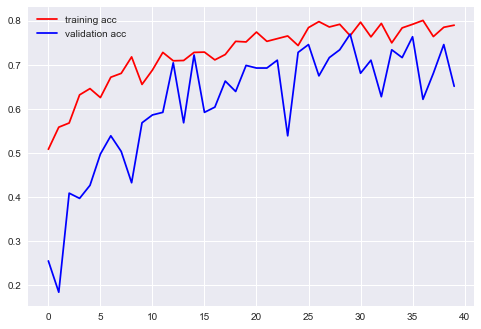

In [56]:
plt.style.use("seaborn")

plt.plot(hist.history['accuracy'],label="training acc",c='red')
plt.plot(hist.history['val_accuracy'],label="validation acc",c='blue')
plt.legend()
plt.show()

## Loading test data and Getting predictions

In [77]:
path = "Test/"
y_df = pd.read_csv(path+"sample_submission.csv")
y_df.shape

(187, 2)

In [78]:
y_df.head()

,Name,Class
0,test_32.jpg,0
1,test_147.jpg,0
2,test_171.jpg,0
3,test_114.jpg,0
4,test_162.jpg,0


In [79]:
y_df.drop(['Class'],inplace=True,axis=1)

In [80]:
y_df=y_df.values.reshape((-1,))
print(y_df.shape)

(187,)


In [105]:
from pathlib import Path
pi_test=Path("Test/images/")

image_data_test=[]
label_test=[]

for image_path in pi_test.glob("*"):
    label=(str(image_path).split("\\")[-1])
    img=image.load_img(image_path,target_size=(224,224,3))
    image_array=image.img_to_array(img)/255.0
    image_data_test.append(image_array)
    label_test.append(label)

In [106]:
image_data_test=np.array(image_data_test)

In [107]:
print(image_data_test.shape, len(label_test), sep='\n')

(187, 224, 224, 3)
187


In [108]:
y_predicted=model.predict_classes(image_data_test)
y_predicted

C:\Users\rrite\anaconda3\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([0, 0, 1, 6, 6, 6, 6, 7, 6, 6, 6, 1, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 1, 6, 6, 8, 6, 6, 6, 8, 5, 5, 6, 1, 7, 7, 7, 7, 7, 4, 5, 7,
       4, 7, 1, 7, 8, 7, 3, 7, 7, 8, 4, 8, 8, 1, 8, 0, 4, 8, 8, 7, 8, 8,
       8, 5, 1, 9, 5, 8, 0, 9, 8, 4, 9, 9, 9, 1, 9, 1, 0, 9, 1, 9, 7, 1,
       9, 9, 1, 9, 9, 7, 9, 2, 0, 9, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 2, 2, 5, 4, 4, 2, 2, 2, 2,
       0, 2, 2, 2, 4, 2, 2, 4, 2, 2, 2, 0, 2, 9, 2, 2, 2, 2, 2, 2, 2, 3,
       0, 3, 3, 3, 0, 0, 3, 1, 3, 3, 0, 0, 0, 9, 4, 0, 4, 4, 4, 4, 7, 4,
       0, 4, 5, 4, 8, 5, 5, 5, 5, 8, 5], dtype=int64)

In [110]:
y_pre=[]
for i in range(image_data_test.shape[0]):
    index=label_test.index(y_df[i])
    y=y_predicted[index]
    y_pre.append((y_df[i],y))

In [112]:
y_pre=np.array(y_pre)

In [114]:
df_pre=pd.DataFrame(data=y_pre,columns=['Name','Class'])

In [115]:
df_pre.to_csv('y_predict_of_pokedex_learning_own_features1.csv',index=False)